# Notebook of Figure 9 of manuscript titled: _Variability of the kinetic energy in seasonally ice-covered oceans_.
by Josue Martinez-Moreno, Camille Lique, Claude Talandier, Quentin
Jamet, & Anne-Marie Treguier

This figure shows diagnostics of the dissipation of eddies by sea-ice.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm

import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43585,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35348,Total threads: 1
Dashboard: http://127.0.0.1:48350/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:49847,


In [4]:
from utils import Import_Expt_Front, date_fmt

# Load data

In [5]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [6]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007',"expt_008","expt_009",'expt_250m_test']

In [7]:
dataset_u_1d = EXF.import_multipe_expt('grid_U',vars_of_interest=['uoce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [8]:
dataset_τᵤ_1d = EXF.import_multipe_expt('grid_U',vars_of_interest=['utau'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")

In [9]:
dataset_v_1d = EXF.import_multipe_expt('grid_V',vars_of_interest=['voce'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [10]:
dataset_τᵥ_1d = EXF.import_multipe_expt('grid_V',vars_of_interest=['vtau'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1}).sel(time_counter="0002")

In [11]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc')

## Compute and pre-processing of data

In [12]:
def interp_field(x,y):
    x_centered = (x + x.roll(x=1))/2
    y_centered = (y + y.roll(y=1))/2
    return x_centered,y_centered

In [13]:
# Interpolate velocities
τᵤ_1d, τᵥ_1d = interp_field(dataset_τᵤ_1d.utau_006,dataset_τᵥ_1d.vtau_006)

In [14]:
# Interpolate velocities
u_1d, v_1d = interp_field(dataset_u_1d.uoce_006.isel(depthu=0).squeeze(),dataset_v_1d.voce_006.isel(depthv=0).squeeze())

In [15]:
rho0 = 1026

In [16]:
Eddy_killing = (τᵤ_1d*u_1d + τᵥ_1d*v_1d)/rho0

In [17]:
from utils import compute_PSD, compute_PSD_dataset 

In [18]:
data = Eddy_killing.isel(y=slice(300,900)).load()

In [19]:
def compute_PSD_dataset(dataset,indx=None):    
    dataset_dict = {}
    for var in list(dataset.data_vars):
        if indx!=None:
            FFT, PSD, om_welch = compute_PSD(dataset[var].isel(indx),dx=250)
        else:
            FFT, PSD, om_welch = compute_PSD(dataset[var],dx=250)
            
        dataset_dict[var+"_FFT"] = {'dims':('n','x'),'data': FFT} 
        dataset_dict[var+"_PSD"] = {'dims':('n','x'),'data':PSD,'attrs':{'long_name':dataset[var].long_name,'units':dataset[var].units}} 
        dataset_dict[var+"_om"] = {'dims':('n','x'),'data':om_welch}
    dataset = xr.Dataset.from_dict(dataset_dict)
    return dataset

def compute_PSD_dataset_2D(dataset,var,indx=None):    
#     dataset_dict = dataset.copy()
#     dataset_dict.expand_dims(dim={"axis": len(dataset[indx])})
    dataset_dict=[]
    for ii in dataset[indx].values:
        dataset_out = compute_PSD_dataset(dataset.sel({indx:ii}))
        dataset_dict.append(dataset_out)
        concat_dataset = xr.concat(dataset_dict,dim="y")
    concat_dataset['n']=dataset.time_counter.values
    return concat_dataset.rename({"n":"time"}).transpose("time","x","y")

In [20]:
data = data.to_dataset(name= "eddy_killing")

In [21]:
data.eddy_killing.attrs={"long_name":"eddy killing","units":"mW/m2"}

In [22]:
# Compute spectra and store it.
# PSD_ke = compute_PSD_dataset_2D(data,'eddy_killing','y')
# PSD_ke.to_netcdf('storage/spectra_surface_full_eddy_killing.nc')

## Load spectra

In [23]:
PSD_ke = xr.open_dataset('storage/spectra_surface_full_eddy_killing.nc')

In [24]:
seasonal_EK = Eddy_killing.groupby('time_counter.season').mean().compute()

In [25]:
seasonal_EK = seasonal_EK.assign_coords({"nav_lon":grid.x_coord,"nav_lat":grid.y_coord})

## Load Rossby radius of deformation

In [26]:
R1_ts = xr.open_dataset("./storage/Rossby_radius.nc")

In [27]:
R1min = np.min(R1_ts.bn2_006).values/1000
R1max = np.max(R1_ts.bn2_006).values/1000

## Plot utils

In [28]:
import matplotlib

def add_distance_axis_log(ax,fontsize=12):
    ax_ = ax.twiny()

    ax_.set_xscale('log')
    ax_.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax_.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax_.spines['bottom'].set_position(('outward', 36))
    ax_.set_xlim(ax.get_xlim())
    ax_.set_xlabel("Wavelength [km]", fontsize= fontsize)


    labels = ax_.get_xticklabels()
    new_label=list(np.zeros(len(labels)))
    count=0
    for label in labels:
        nl = np.round(1 / label.get_position()[0], 1)
        if nl==np.inf:
            new_label[count] = "Inf"
        else:
            new_label[count] = "{0}".format(nl)
        count+=1

    ax_.set_xticklabels(new_label)
    
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(1/np.arange(1,10)),numticks=12)
    ax_.xaxis.set_minor_locator(locmin)
    ax_.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
    return ax_


## Plotting

/dev/shm/pbs.3989604.datarmor0/ipykernel_6518/445338427.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_.set_xticklabels(new_label)


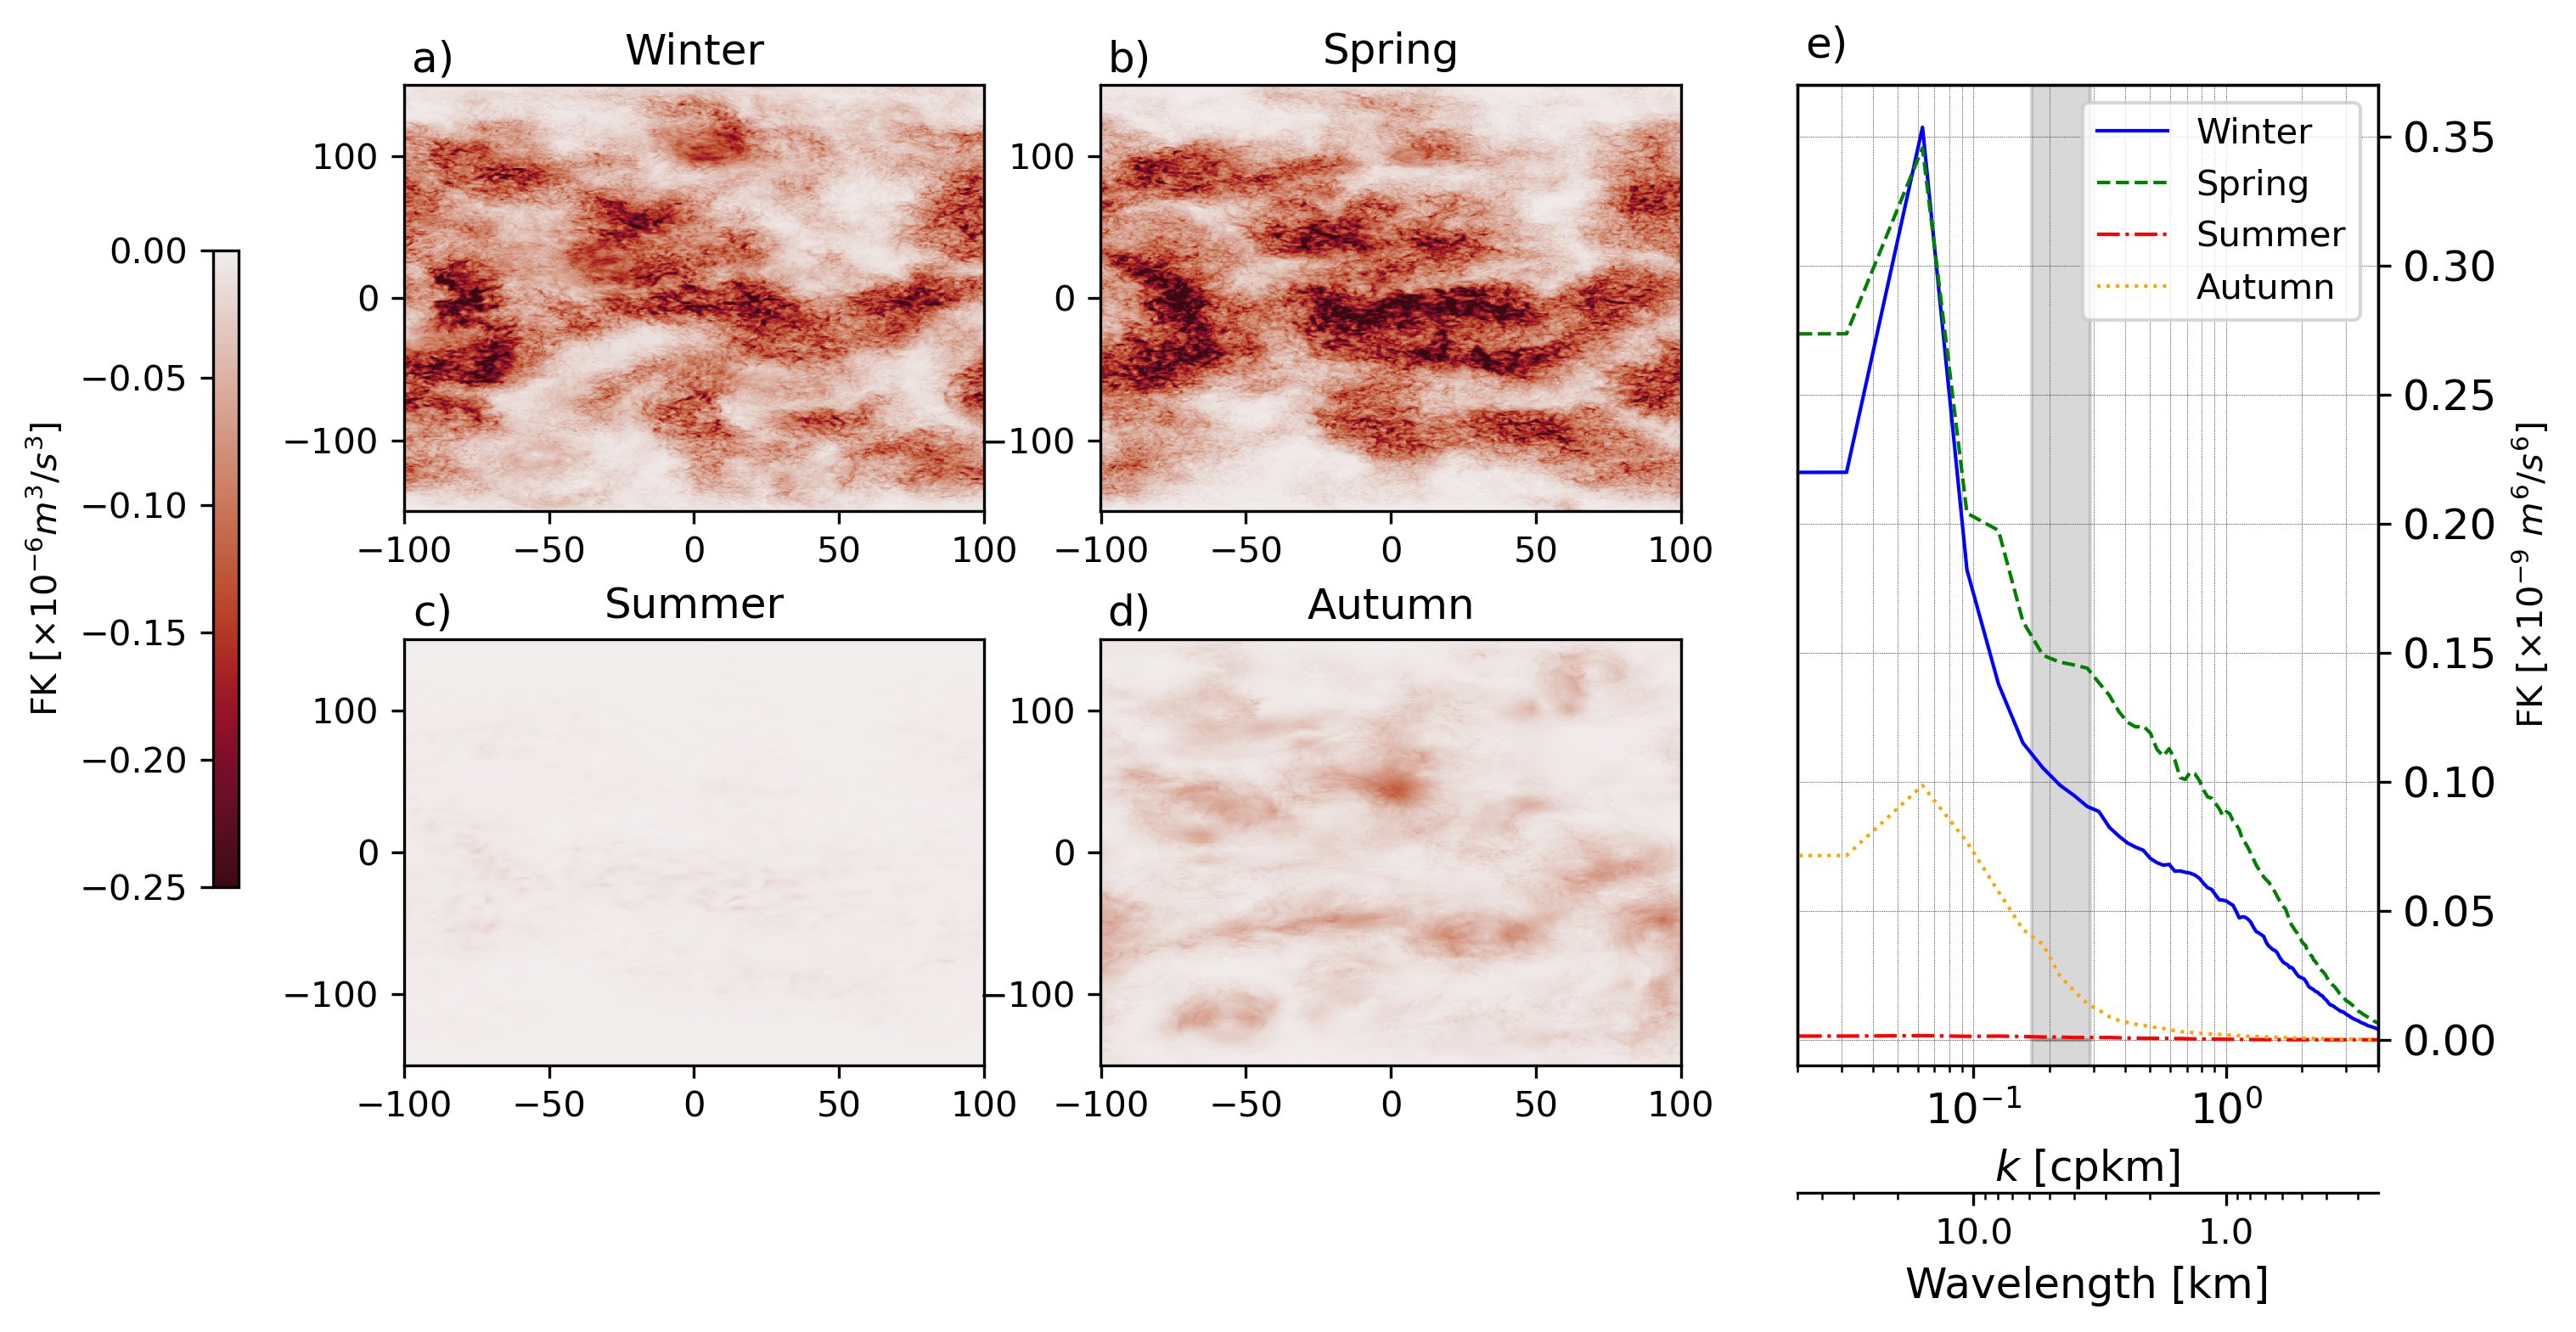

In [29]:
fig = plt.figure(figsize=(10,5), dpi=300)

gs0 = gridspec.GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs0[:, 2])
ax2 = fig.add_subplot(gs0[0, 0])
ax3 = fig.add_subplot(gs0[1, 0])
ax4 = fig.add_subplot(gs0[0, 1])
ax5 = fig.add_subplot(gs0[1, 1])

xaxis = PSD_ke["eddy_killing_om"].mean('y')*1000
PSD =  PSD_ke["eddy_killing_PSD"].mean('y')
mean_PSD = PSD.groupby("time.season").mean()

min_PSD = 10 * PSD_ke["eddy_killing_PSD"].min('y').groupby("time.season").mean()
max_PSD = PSD_ke["eddy_killing_PSD"].max('y').groupby("time.season").mean()

ax1.plot(xaxis[0,:],(1e9*mean_PSD).sel(season="DJF"),linewidth=1,color="blue",zorder=3, label="Winter")

ax1.plot(xaxis[0,:],(1e9*mean_PSD).sel(season="MAM"),linewidth=1,color="green",zorder=3, label="Spring",linestyle="--")

ax1.plot(xaxis[0,:],(1e9*mean_PSD).sel(season="JJA"),linewidth=1,color="red",zorder=3, label="Summer",linestyle="-.")

ax1.plot(xaxis[0,:],(1e9*mean_PSD).sel(season="SON"),linewidth=1,color="orange",zorder=3, label="Autumn",linestyle=":")

ax1.set_xscale('log')

ax1.grid()

ax1.set_xlabel(r'$k$ [cpkm]', fontsize= 12 )
ax1.tick_params(labelsize=12)
ax1.grid(which='major', linestyle=':', linewidth='0.2', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
# ax1.axvline(x=1/L2,color='k', ls = ':', label=r"$2\pi R_d$")
ax1.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[-1e-5,-1e-5,0.00037,0.00037],color='gray',alpha=0.3)
ax1.set_title(r'Eddy Killing')

ax1.legend()
ax1.set_xlim((1/50,1/0.25))

add_distance_axis_log(ax1)

ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_label_position('right')

cb_1 = (1e6*seasonal_EK).sel(season="DJF").plot(x="nav_lon", y="nav_lat", ax=ax2, vmin=-0.25, vmax=0, add_colorbar=False, cmap=cm.cm.amp_r,rasterized=True)
(1e6*seasonal_EK).sel(season="JJA").plot(x="nav_lon", y="nav_lat", ax=ax3, vmin=-0.25, vmax=0, add_colorbar=False, cmap=cm.cm.amp_r,rasterized=True)
(1e6*seasonal_EK).sel(season="MAM").plot(x="nav_lon", y="nav_lat", ax=ax4, vmin=-0.25, vmax=0, add_colorbar=False, cmap=cm.cm.amp_r,rasterized=True)
(1e6*seasonal_EK).sel(season="SON").plot(x="nav_lon", y="nav_lat", ax=ax5, vmin=-0.25, vmax=0, add_colorbar=False, cmap=cm.cm.amp_r,rasterized=True)

ax = [ax1,ax2,ax3,ax4,ax5]

[a.set_title("") for a in ax ]
[a.set_xlabel("") for a in ax ]
[a.set_ylabel("") for a in ax ]

ax2.set_title("Winter")
ax3.set_title("Summer")
ax4.set_title("Spring")
ax5.set_title("Autumn")

cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
cbar = fig.colorbar(cb_1, cax=cax, orientation='vertical')
cbar.set_label(r"FK [$\times 10^{-6} m^3/s^3$]")
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')

# cax = fig.add_axes([0.94, 0.15, 0.01, 0.25])
# cbar = fig.colorbar(cb_2, cax=cax, orientation='vertical')
# cbar.set_label(r"$mW/m^2$")


ax1.set_xlabel(r'$k$ [cpkm]')
ax1.set_ylabel(r"FK [$\times 10^{-9}\ m^6/s^6$]")
ax1.set_ylim(-1e-2,0.37)

ax1.fill_between([1/R1min,1/R1max,1/R1max,1/R1min],[-7.5,-7.5,2.5,2.5],color='gray',alpha=0.3)

ax1.text(0.05, 1.04, 'e)', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=12)
ax2.text(0.05, 1.06, 'a)', horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes,fontsize=12)
ax4.text(0.05, 1.06, 'b)', horizontalalignment='center', verticalalignment='center', transform = ax4.transAxes,fontsize=12)
ax3.text(0.05, 1.06, 'c)', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes,fontsize=12)
ax5.text(0.05, 1.06, 'd)', horizontalalignment='center', verticalalignment='center', transform = ax5.transAxes,fontsize=12)

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figures/Fig_9_eddy_killing.pdf', dpi=300, bbox_inches='tight')

**Figure 9.** Spatial pattern of the mean ice-induced eddy dissipation term (or ice work) for a) winter, b) spring, c) summer, and d) autumn. e) Seasonal spectra of the ice-induced eddy dissipation term. The grey vertical shaded area in pannel e) correspond to the Rossby radius ($R_D$) range within the second year of the simulation.

## Extra diagnostics

In [30]:
seasonal_EK.mean(('x','y')).compute()

<xarray.DataArray (season: 4)> Size: 16B
array([-6.8149831e-08, -2.3048334e-09, -7.8591889e-08, -1.7931940e-08],
      dtype=float32)
Coordinates:
    depthu   float32 4B 0.5
    depthv   float32 4B 0.5
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

In [31]:
seasonal_EK.median(('x','y')).compute()

<xarray.DataArray (season: 4)> Size: 16B
array([-5.5324300e-08, -1.6606362e-09, -6.5884144e-08, -1.3256381e-08],
      dtype=float32)
Coordinates:
    depthu   float32 4B 0.5
    depthv   float32 4B 0.5
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

In [32]:
seasonal_EK.max(('x','y')).compute()

<xarray.DataArray (season: 4)> Size: 16B
array([0., 0., 0., 0.], dtype=float32)
Coordinates:
    depthu   float32 4B 0.5
    depthv   float32 4B 0.5
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

In [33]:
seasonal_EK.min(('x','y')).compute()

<xarray.DataArray (season: 4)> Size: 16B
array([-4.1996347e-07, -2.6271051e-08, -4.9226600e-07, -1.2609712e-07],
      dtype=float32)
Coordinates:
    depthu   float32 4B 0.5
    depthv   float32 4B 0.5
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'